# Thesis Ruben Doorn: General gist

My thesis set out to extract genomic characteristics out of sequencing data related to Copy Number Variations, and construct a machine learning classifier to link these features to copy number deletions or duplications. As for confidentiality issues, I show the general idea of the process in this notebook on a toy dataset

## Model Optimization

Prior to completely train the machine learning classifier, I wanted to experiment with several optimization algorithms: 
- GridSearch 
- RandomizedSearch 
- Tree-Parze Estimator (TPE) 
- Simulated Anneal (SA) 

And measure the time they take to find the global optimum parameters

In [207]:
# General / preprocessing
import argparse
import errno
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime
import pandas as pd
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Optimization and training
from sklearn.model_selection import RepeatedKFold, KFold, GridSearchCV, ParameterGrid
from hyperopt import fmin, hp, STATUS_OK, tpe, anneal, Trials, rand
from functools import partial

# Machine
from xgboost import XGBClassifier

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

# Evaluation
from sklearn.metrics import fbeta_score, f1_score ,make_scorer, classification_report, roc_auc_score, confusion_matrix, roc_curve, accuracy_score, auc, recall_score

# Visualization
import matplotlib.pyplot as plt
import scikitplot as skplt

# Random State / Random Seed-seed
np.random.seed(420)

First we'll have to load our data and take a look at it:

In [208]:
data = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")
target = "Diabetes_binary"
data.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [209]:
# Scale the features, not the target
ssc = StandardScaler() # Createa scaler object
# transform data
sdf = pd.DataFrame(ssc.fit_transform(data.loc[:, ~data.columns.isin([target])]),  # Scale all data, except target
columns = data.loc[:, ~data.columns.isin([target])].keys()) # Get column names
data = pd.concat([sdf, data[target]], axis=1) # Concat back into dataframe

data.describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
count,2.536800e+05,2.536800e+05,2.536800e+05,2.536800e+05,2.536800e+05,2.536800e+05,2.536800e+05,2.536800e+05,2.536800e+05,2.536800e+05,...,2.536800e+05,2.536800e+05,2.536800e+05,2.536800e+05,2.536800e+05,2.536800e+05,2.536800e+05,2.536800e+05,2.536800e+05,253680.000000
mean,8.756754e-15,-1.106757e-14,1.009144e-14,-8.566109e-17,6.702429e-15,1.325996e-14,-8.808645e-15,2.754728e-14,-3.087942e-14,5.123383e-15,...,3.893385e-15,3.318194e-14,1.857992e-14,-6.296298e-15,2.007023e-14,1.435552e-15,3.222375e-15,2.219262e-14,-3.107282e-15,0.139333
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.346294
min,-8.667854e-01,-8.581816e-01,-5.078164e+00,-2.478916e+00,-8.921186e-01,-2.056365e-01,-3.224576e-01,-1.762814e+00,-1.316872e+00,-2.074316e+00,...,-3.031731e-01,-1.414532e+00,-4.296296e-01,-4.865924e-01,-4.497181e-01,-8.870209e-01,-2.302431e+00,-4.108894e+00,-2.440138e+00,0.000000
25%,-8.667854e-01,-8.581816e-01,1.969216e-01,-6.631223e-01,-8.921186e-01,-2.056365e-01,-3.224576e-01,5.672748e-01,-1.316872e+00,4.820866e-01,...,-3.031731e-01,-4.786188e-01,-4.296296e-01,-4.865924e-01,-4.497181e-01,-8.870209e-01,-6.653492e-01,-1.065595e+00,-5.088373e-01,0.000000
50%,-8.667854e-01,-8.581816e-01,1.969216e-01,-2.091739e-01,-8.921186e-01,-2.056365e-01,-3.224576e-01,5.672748e-01,7.593754e-01,4.820866e-01,...,-3.031731e-01,-4.786188e-01,-4.296296e-01,-4.865924e-01,-4.497181e-01,-8.870209e-01,-1.051636e-02,-5.116153e-02,4.568129e-01,0.000000
75%,1.153688e+00,1.165254e+00,1.969216e-01,3.960906e-01,1.120927e+00,-2.056365e-01,-3.224576e-01,5.672748e-01,7.593754e-01,4.820866e-01,...,-3.031731e-01,4.572943e-01,-1.598272e-01,-1.424742e-01,-4.497181e-01,1.127369e+00,6.443165e-01,9.632716e-01,9.396380e-01,0.000000
max,1.153688e+00,1.165254e+00,1.969216e-01,1.053427e+01,1.120927e+00,4.862949e+00,3.101183e+00,5.672748e-01,7.593754e-01,4.820866e-01,...,3.298445e+00,2.329121e+00,3.617407e+00,2.954590e+00,2.223615e+00,1.127369e+00,1.626566e+00,9.632716e-01,9.396380e-01,1.000000


We notice that the data has 8 continues features, with a target variable outcome, indicating the person has Diabetes. There is no missing data, so we don't have to impute anything. So we can continue with preproccesing for machine learning.

In [232]:
def Get_features(df, unused_features=[], target='Diabetes_binary'): # Returns 
    nunique = df.nunique()
    types = df.dtypes
    
    # Empty list/dict for data storage
    categorical_columns = []
    categorical_dims =  {}
    for col in df.columns: # Iterate over all columns
        if col not in unused_features:
            if types[col] == 'object' or nunique[col] < 15: # If column contains object or less than 15 unique values
                #print(col, data[col].nunique()) # Print the column and the number of unique values
                l_enc = LabelEncoder() # Define the encoder
                df[col] = l_enc.fit_transform(df[col].values) # Ensure that values are 0, 1, 2 .... 
                categorical_columns.append(col) # Append categorical column to storage list
                categorical_dims[col] = len(l_enc.classes_) # Append number of classes to dictionary corresponding to catagorical feature
    ############################################################################################
    
    features = [ col for col in df.columns if col not in unused_features+[target]] # Determine which colnames are the features 
    return(features)

def TVT_split(df, target, pt=0.2, pv=0.2, seed=420):
    '''
    This function inputs a dataframe, and seperates it int a train, validation and test dataset,
    accorcing to the specified fractions.
    '''
    
    traindf, test = train_test_split(df, test_size = pt, random_state = seed, stratify = df[target])
    
    # Compute how big a fraction we need to take from the training set to get the desired validation set
    val_frac_after_test_split = pv / (1 - pt)
    
    train, val = train_test_split(traindf, test_size = val_frac_after_test_split, random_state = seed, stratify = traindf[target])
    return(train, val, test)
    

def XYsplit(df, target, drop=None):
    '''
    This function splits the dataframe into the Features (X) and Target (y)
    '''
    cols = [target]
    if drop != None and type(drop) == str:
        cols.append(drop)
    elif drop != None and type(drop) == list:
        cols = cols + drop
    return(df.drop(cols, axis=1).to_numpy(), df[target].to_numpy())


As we are working with a fairly large dataset, we take a subsample to test and evaluate the optimization algorithms

In [218]:
print("Shape of the original data: {}".format(data.shape))
print("Class distribution of the original data: {}".format(Counter(data[target])))
data_sub = data.sample(int(data.shape[0]*0.05)) 
print("Shape of the sampled data: {}".format(data_sub.shape))
print("Class distribution of the sampled data: {}".format(Counter(data_sub[target])))

Shape of the original data: (253680, 22)
Class distribution of the original data: Counter({0.0: 218334, 1.0: 35346})
Shape of the sampled data: (12684, 22)
Class distribution of the sampled data: Counter({0.0: 10868, 1.0: 1816})


In [234]:
# Get the features
features = Get_features(data_sub)

# Split into a train, validation and test set
df_train, df_valid, df_test = TVT_split(data_sub, target, pt=0.2, pv=0.2, seed=420)

# Seperate the features from the target
X_train, y_train = XYsplit(df_train, target)
X_valid, y_valid = XYsplit(df_valid, target)
X_test, y_test = XYsplit(df_test, target)

In [221]:
# Check if all sets are equally divided 
print(Counter(df_train[target])[0]/Counter(df_train[target])[1])
print(Counter(df_valid[target])[0]/Counter(df_valid[target])[1])
print(Counter(df_test[target])[0]/Counter(df_test[target])[1])
# In this case, they all have the same ratio Negative:Positive

5.981651376146789
5.988980716253444
5.988980716253444


With out datasets ready, we can start optimizing. Firstly, we'll have to create a function to optimize. As in our case we want to optimize A TabNet model, we'll have to create a function that takes input data and trains the model, compute a score and returns it.

In [259]:
def xgb_cv(params, 
           X_train, y_train,
           X_val, y_val,
           X_test, y_test,
           cv,
           metric='f1',
           give='model'):
    '''
    Function to be optimized. Gets called by fmin(), which passes the parameters.
    '''
    
    # the function gets a set of variable parameters in "param"
    params = {'objective':'binary:logistic',
              'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
              'learning_rate': params['learning_rate'],
             'scale_pos_weight':Counter(y_train)[0]/Counter(y_train)[1]}

    # we use this params to create a new XGBoost classifier
    model = XGBClassifier(**params)
    
    # and then conduct the cross validation with the same folds as before
#     model.fit(X_train, y_train,  eval_set=[(X_val, y_val)])
    
    if give == 'score':
        fit_params={'verbose': False,
                'eval_set': [[X_val, y_val]]}
        score =  cross_val_score(model, X_train, y_train, 
                            cv=cv, n_jobs=-1, scoring=metric, fit_params = fit_params).mean()
    
#         y_hat = model.predict(X_test)
#         score = f1_score(y_test, y_hat)
        return {'loss': -score, 'status': STATUS_OK}
    elif give == 'model':
        model.fit(X_train, y_train,  eval_set=[(X_val, y_val)], verbose=False)
        return(model)

Before we try to optimize our TabNet model, we run a raw run with the default parameters:

In [227]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

# Dictionary with the default parameters (https://github.com/dreamquark-ai/tabnet)
params = {'n_estimators': 100,
         'max_depth': 6,
         'learning_rate': 0.3
        }

# Train a model without pretraining
XGB_def = xgb_cv(params,  X_train, y_train, X_valid, y_valid, X_test, y_test, kf, give="model")

We can now take a look at the feature importances, and how both models assign different importances to different features:

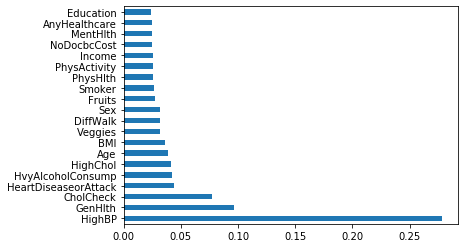

In [236]:
feat_importances = pd.Series(XGB_def.feature_importances_, index=features)
feat_importances.nlargest(20).plot(kind='barh')

It seems that the both models consider High Blood Pressure the most significant indicator for Diabetes. Let's see how the model performs with its predictive abilities:

In [237]:
# Make the predictions:
y_hat_xgb =  XGB_def.predict(X_test)

print("Classification report and confusion matrix for without pretraining")
print(classification_report(y_test, y_hat_xgb))
print(confusion_matrix(y_test, y_hat_xgb))
print("AUC score: {}".format(roc_auc_score(y_test, y_hat_xgb)))


Classification report and confusion matrix for without pretraining
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      2174
           1       0.21      0.16      0.18       363

    accuracy                           0.80      2537
   macro avg       0.54      0.53      0.53      2537
weighted avg       0.77      0.80      0.78      2537

[[1958  216]
 [ 304   59]]
AUC score: 0.5315892047513692


We see that the model performs very poorly on predicting the positive class, but predict normal cases fairly well. Overal the model has an AUC score of 0.53, which indicates it performs just slightly better than random guessing... Let's see if we can increase this score by optimizing some parameters

## Optimization

### Grid optimization

In [243]:
%%time


param_grid={ 'n_estimators': np.linspace(100,1000,4,dtype = int),
             'max_depth': np.linspace(2,12,4,dtype = int),
             'learning_rate':np.logspace(-3,0, num=3)
            }

params_list = list(ParameterGrid(param_grid))

scores_grid = []

for i in range(len(params_list)):
    scores_grid.append(xgb_cv(params_list[i], X_train, y_train, X_valid, y_valid, X_test, y_test, kf, metric='f1', give="score"))
    print("Model {} trained with score of {}".format(i, scores_grid[i]))

Model 0 trained with score of {'loss': -0.416512520181588, 'status': 'ok'}
Model 1 trained with score of {'loss': -0.4124060256544994, 'status': 'ok'}
Model 2 trained with score of {'loss': -0.4253533238998239, 'status': 'ok'}
Model 3 trained with score of {'loss': -0.429474244680008, 'status': 'ok'}
Model 4 trained with score of {'loss': -0.42221270418754686, 'status': 'ok'}
Model 5 trained with score of {'loss': -0.4257389113800619, 'status': 'ok'}
Model 6 trained with score of {'loss': -0.43109291632365626, 'status': 'ok'}
Model 7 trained with score of {'loss': -0.429111426834685, 'status': 'ok'}
Model 8 trained with score of {'loss': -0.413227758465735, 'status': 'ok'}
Model 9 trained with score of {'loss': -0.41884031815886524, 'status': 'ok'}
Model 10 trained with score of {'loss': -0.428501386372632, 'status': 'ok'}
Model 11 trained with score of {'loss': -0.4198461279856188, 'status': 'ok'}
Model 12 trained with score of {'loss': -0.3955996097408528, 'status': 'ok'}
Model 13 tr

In [244]:
gridscores = []
for i in scores_grid:
    gridscores.append(-i['loss'])
best_params_grid = params_list[gridscores.index(max(gridscores))] # parameters that yielded the highest score
print(best_params_grid)

{'learning_rate': 0.03162277660168379, 'max_depth': 2, 'n_estimators': 400}


In [245]:
# Train the model with the best params found:
xgb_grid = xgb_cv(best_params_grid, X_train, y_train, X_valid, y_valid, X_test, y_test, kf, metric='f1', give="model")

In [269]:
# Make the predictions:
y_hat_grid =  xgb_grid.predict(X_test)

print("Classification report and confusion matrix")
print(classification_report(y_test, y_hat_grid))
print(confusion_matrix(y_test, y_hat_grid))
print("AUC score: {}".format(roc_auc_score(y_test, y_hat_grid)))

Classification report and confusion matrix
              precision    recall  f1-score   support

           0       0.96      0.71      0.82      2174
           1       0.32      0.81      0.46       363

    accuracy                           0.73      2537
   macro avg       0.64      0.76      0.64      2537
weighted avg       0.87      0.73      0.77      2537

[[1547  627]
 [  69  294]]
AUC score: 0.7607544458552237


With Gridsearch, we already achieved an increase of 0.229 in AUC! We observe a significant decrease in false negatives, however, we still have a lot of false positives..

Although it's a significant better model than the one running with standard parameters, the downside is that we had to test every single combination within our parametergrid. Let's see how we achieve with other optimization strategies. 

## Hyperoptimization init

Before we can use Hyperopt, we'll have to minimize our function, so it only takes the parameters as input.

In [247]:
opt_fn = partial(xgb_cv, #Function to optimize
                X_train=X_train,
                y_train=y_train,
                X_val=X_valid,
                y_val=y_valid,
                X_test=X_test,
                y_test=y_test,
                cv=kf,
                metric='f1',
                give='score'
                )  
# Now opt_fn is a function of a single variable, params  

# We define our searchspace
space = {'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
             'max_depth': hp.quniform('max_depth', 2, 16, 1),
             'learning_rate': hp.loguniform('learning_rate', -5, 0)}
n_iter = 48  # Keep number of iterations equal to GridSearch

### Random search

In [248]:
%%time
trials = Trials()

best_rand=fmin(fn = opt_fn, # function to optimize
          space=space, 
          algo=rand.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials # logging
         )

100%|██████████| 48/48 [10:35<00:00, 13.24s/trial, best loss: -0.45387681907215016]
Wall time: 10min 35s


In [249]:
best_rand

{'learning_rate': 0.021782301601911847,
 'max_depth': 3.0,
 'n_estimators': 280.0}

In [250]:
# Train the model with the best params found:
xgb_rand = xgb_cv(best_rand,  X_train, y_train, X_valid, y_valid, X_test, y_test, kf,metric='f1', give="model")

In [268]:
# Make the predictions:
y_hat_rand =  xgb_rand.predict(X_test)

print("Classification report and confusion matrix")
print(classification_report(y_test, y_hat_rand))
print(confusion_matrix(y_test, y_hat_rand))
print("AUC score: {}".format(roc_auc_score(y_test, y_hat_rand)))

Classification report and confusion matrix
              precision    recall  f1-score   support

           0       0.96      0.71      0.81      2174
           1       0.31      0.80      0.45       363

    accuracy                           0.72      2537
   macro avg       0.63      0.76      0.63      2537
weighted avg       0.86      0.72      0.76      2537

[[1536  638]
 [  71  292]]
AUC score: 0.7554697261145368


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A7F5E43C08>,
      dtype=object)

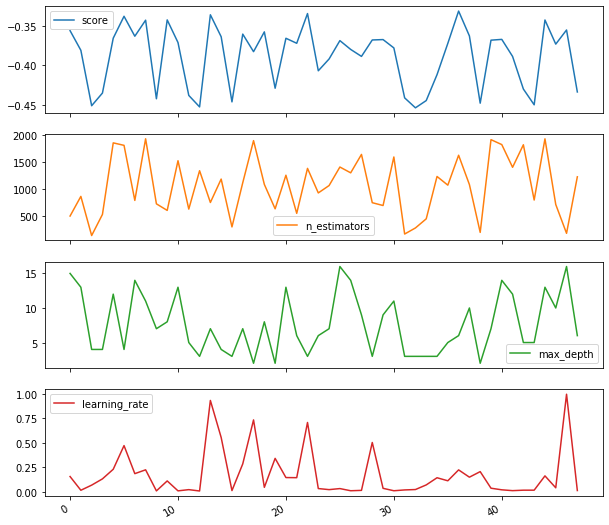

In [252]:
random_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['learning_rate'][0]] for x in trials.trials])

random_results_df=pd.DataFrame(random_results,
                           columns=['score', 'n_estimators', 'max_depth', 'learning_rate'])
random_results_df.plot(subplots=True,figsize=(10, 10))

With Randomsearch, we find again a slightly higher score than what we find with GridSearch. However, we still have a very high amount of false positives...

### TPE search

In [253]:
%%time
trials = Trials()

best_tpe=fmin(fn = opt_fn, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials # logging
         )

100%|██████████| 48/48 [07:44<00:00,  9.67s/trial, best loss: -0.45619694240397834]
Wall time: 7min 44s


In [254]:
# Train the model with the best params found:
xgb_tpe = xgb_cv(best_tpe, X_train, y_train, X_valid, y_valid,X_test,y_test, kf ,metric='f1', give="model")

In [267]:
# Make the predictions:
y_hat_tpe =  xgb_tpe.predict(X_test)

print("Classification report and confusion matrix")
print(classification_report(y_test, y_hat_tpe))
print(confusion_matrix(y_test, y_hat_tpe))
print("AUC score: {}".format(roc_auc_score(y_test, y_hat_tpe)))

Classification report and confusion matrix
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      2174
           1       0.32      0.78      0.45       363

    accuracy                           0.73      2537
   macro avg       0.64      0.75      0.64      2537
weighted avg       0.86      0.73      0.77      2537

[[1569  605]
 [  79  284]]
AUC score: 0.7520401387801237


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A7F5913388>,
      dtype=object)

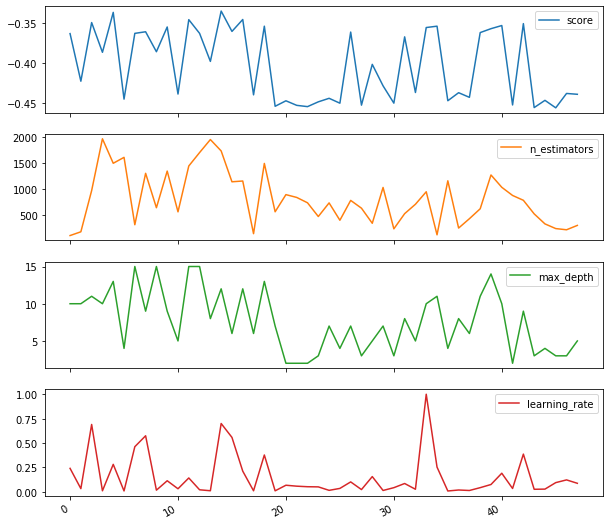

In [256]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['learning_rate'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'n_estimators', 'max_depth', 'learning_rate'])
tpe_results_df.plot(subplots=True,figsize=(10, 10))

With TPE we obtain almost similar results as with randomized search. Let's see how Simulated Anneal goes.

### Simulated Anneal

In [257]:
%%time
trials = Trials()

best_sa=fmin(fn = opt_fn, # function to optimize
          space=space, 
          algo=anneal.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials # logging
         )

100%|██████████| 48/48 [07:06<00:00,  8.89s/trial, best loss: -0.4545158473849127] 
Wall time: 7min 6s


In [260]:
# Train the model with the best params found:
xgb_sa = xgb_cv(best_sa,  X_train, y_train, X_valid, y_valid, X_test, y_test, kf, metric='f1', give="model")

In [266]:
# Make the predictions:
y_hat_sa =  xgb_sa.predict(X_test)

print("Classification report and confusion matrix")
print(classification_report(y_test, y_hat_sa))
print(confusion_matrix(y_test, y_hat_sa))
print("AUC score: {}".format(roc_auc_score(y_test, y_hat_sa)))

Classification report and confusion matrix
              precision    recall  f1-score   support

           0       0.96      0.71      0.82      2174
           1       0.32      0.80      0.45       363

    accuracy                           0.72      2537
   macro avg       0.64      0.76      0.63      2537
weighted avg       0.86      0.72      0.76      2537

[[1546  628]
 [  72  291]]
AUC score: 0.756392223649897


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A78038F088>,
      dtype=object)

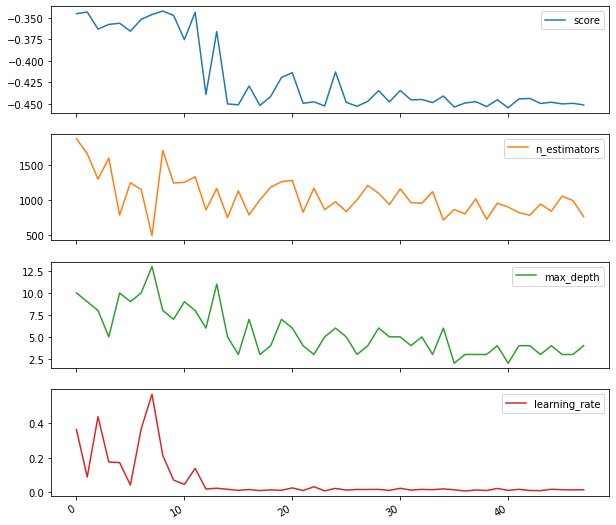

In [262]:
sa_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['learning_rate'][0]] for x in trials.trials])

sa_results_df=pd.DataFrame(sa_results,
                           columns=['score', 'n_estimators', 'max_depth', 'learning_rate'])
sa_results_df.plot(subplots=True,figsize=(10, 10))

## Summarizing

It looks like with all optimization algorithms the global optimum lies around an AUC-SCORE of 0.75. Let's compare all models in their time efficiency

### Runtimes

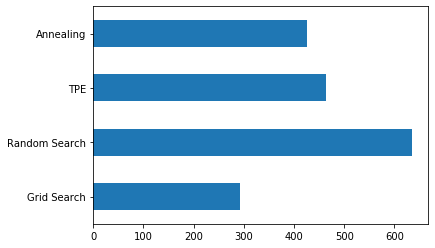

In [277]:
runtimes = pd.Series( [292,635,464,426], index=["Grid Search", "Random Search", "TPE", "Annealing"])
runtimes.plot(kind='barh')

Grid search finished the fastest, but keep in mind it only had a limited search space. The three other strategies had a theorethical limitless search space within a range for each parameter, thus had more options in finding the optimium pair of parameters

### Feature importances

In [292]:
feat_im_df=pd.DataFrame(index=features)

feat_im_df['Default']=XGB_def.feature_importances_
feat_im_df['Grid Search']=xgb_grid.feature_importances_
feat_im_df['Random Search']=xgb_rand.feature_importances_
feat_im_df['TPE']=xgb_tpe.feature_importances_
feat_im_df['Annealing']=xgb_sa.feature_importances_

In [295]:
feat_im_df['mean'] = feat_im_df.mean(axis=1)

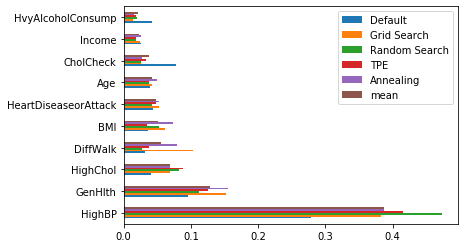

In [298]:
feat_im_df.nlargest(10, 'mean').plot.barh()

Looks like all models agree with the feature importances, with the High Blood Pressure being the biggest indicator for Diabetes.

### How many iterations before we find the global optimum?

In [263]:
all_results_df=pd.DataFrame(list(zip(gridscores, 
                            -random_results_df['score'], 
                            -tpe_results_df['score'], 
                            -sa_results_df['score'])),
                            columns=['grid','random','tpe','sa'])

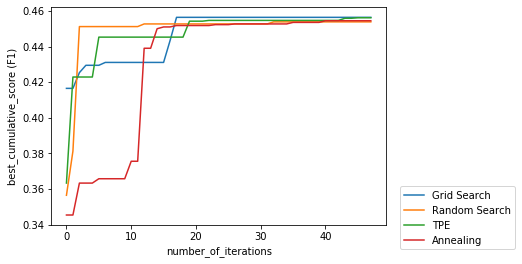

In [264]:
scores_df=pd.DataFrame(index=range(n_iter))

scores_df['Grid Search']=pd.DataFrame(gridscores).cummax()
scores_df['Random Search']=-random_results_df['score'].cummin()
scores_df['TPE']=-tpe_results_df['score'].cummin()
scores_df['Annealing']=-sa_results_df['score'].cummin()

ax = scores_df.plot()

ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score (F1)")

plt.legend(bbox_to_anchor =(1.4, 0.2))

We see that all models find the global optimum around 20 iterations, with Random search finding it the fastest. However, this optimization has been performed on the F1-score, and we still find alot of False positives. To decrease the amount of false positives, we can attemt to optimize using precision

## Decrease False Positives

In [265]:
%%time
opt_fn = partial(xgb_cv, #Function to optimize
                X_train=X_train,
                y_train=y_train,
                X_val=X_valid,
                y_val=y_valid,
                X_test=X_test,
                y_test=y_test,
                cv=kf,
                metric='precision',
                give='score'
                )  

trials = Trials()

sa_precision=fmin(fn = opt_fn, # function to optimize
          space=space, 
          algo=anneal.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials # logging
         )

100%|██████████| 48/48 [21:13<00:00, 26.53s/trial, best loss: -0.4188647732568449] 
Wall time: 21min 13s
Parser   : 106 ms


In [270]:
# Train the model with the best params found:
xgb_precision = xgb_cv(sa_precision,  X_train, y_train, X_valid, y_valid, X_test, y_test, kf, metric='precision', give="model")

In [271]:
# Make the predictions:
y_hat_sa =  xgb_precision.predict(X_test)

print("Classification report and confusion matrix")
print(classification_report(y_test, y_hat_sa))
print(confusion_matrix(y_test, y_hat_sa))
print("AUC score: {}".format(roc_auc_score(y_test, y_hat_sa)))

Classification report and confusion matrix
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2174
           1       0.43      0.36      0.39       363

    accuracy                           0.84      2537
   macro avg       0.66      0.64      0.65      2537
weighted avg       0.83      0.84      0.83      2537

[[2004  170]
 [ 234  129]]
AUC score: 0.6385875143506656


We see that with using precision, we do decrease the false positives, but at the increase of false negatives... Ideally we'd experiment with several metrics, as AUC, F0.5-score, F2-score etc, and determine which combination yields the best performing model. Also, keep in mind that now we only optimized for 3 parameters, while there's dozen more parameters to optimize within XGBoost. Ideally we'd optimize all of them with the best metric, to get the best performing model.